In [275]:
import torch  
from torch_fp.fp_opt import find_fps, fp_mse, clean_fps
from torch_fp import dynamics
%pylab
%load_ext autoreload
%autoreload 2

torch.Tensor.ndim = property(lambda x: len(x.shape)) #for plotting

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lucas/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['angle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [241]:
mpl.get_configdir()

'/home/lucas/.config/matplotlib'

In [2]:
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# GRU and task hyperparameters
u = 1         # Number of inputs to the GRU
n = 100       # Number of units in the GRU
o = 1         # Number of outputs in the GRU

# Optimization hyperparameters
num_batchs = 10000        # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.04          # initial learning rate
decay_factor = 0.9999     # decay the learning rate this much
# Gradient clipping is HUGELY important for training all RNN varieties
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.00002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100          # Print training informatino every so often

In [3]:
def get_noise_dataset(input_params):
    (bval, sval, T, ntimesteps) = input_params
    normal = torch.distributions.normal.Normal(0, 1)
    
    dt = torch.FloatTensor([T/ntimesteps])
    
    bsample = normal.sample([1])
    b = bval * 2. * (bsample - 0.5) 
    
    stddev = sval / torch.sqrt(dt)
    vsample = normal.sample([ntimesteps])
    
    noise = vsample * stddev
    white_noise = noise + b
    
    true_integral = torch.cumsum(white_noise, 0)
    final_target = torch.Tensor([(true_integral[-1] > 0.0)])
    
    target_t = torch.zeros(true_integral.shape[0]-1)
    targets_t = torch.cat([target_t, final_target], dim=0)
    
    return white_noise, targets_t
    
def generate_batch(batch_size, input_params):
    
    noises, targets = [], []
    
    for i in range(batch_size):
        n, t = get_noise_dataset(input_params)
        noises.append(n)
        targets.append(t)
        
    return torch.stack(noises).transpose(1, 0)[:, :, None].cuda(), torch.stack(targets).transpose(1, 0)[:, :, None].cuda()
    
    
    

In [4]:
noise, target = get_noise_dataset(input_params)

tensor([0.0246, 0.2013, 0.1672, 0.1853, 0.3037, 0.5010, 0.6077, 0.6323, 0.7344,
        0.5140, 0.4937, 0.4078, 0.4930, 0.6332, 0.5130, 0.5665, 0.4570, 0.5040,
        0.2985, 0.3401, 0.5415, 0.4011, 0.2632, 0.1875, 0.0967])


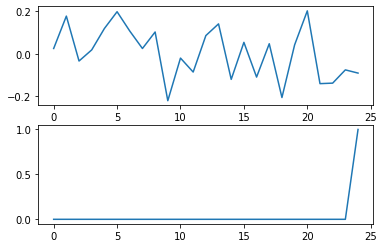

In [5]:
%matplotlib inline
ax = plt.subplot(211)
ax.plot(noise.numpy())
ax = plt.subplot(212)
ax.plot(target.numpy())

print(np.cumsum(noise))

# GRU

In [6]:
class SimpleGRU(torch.nn.Module):
    """
    Just a GRU class, (Kyunghyun Cho et al., 2014). for didactic purposes.
    I suggest you use the standard pytorch GRU class outside of this notebook
    """
    
    def __init__(self, u, n, o, use_cuda=True):
        super(SimpleGRU, self).__init__()
        self.gru = torch.nn.GRUCell(u, n)
        self.readout = torch.nn.Linear(n, o)
        self.init_s = torch.nn.Parameter(torch.randn(1,n))
        
        
    def forward(self, x):
        
        hs = []
        
        batch_size = x.shape[1]
        h = self.init_s.repeat((batch_size, 1))
        for x_t in x:
            h = self.gru(x_t, h)
            hs.append(h)
        out = self.readout(h)
        
        return out, torch.stack(hs)


In [7]:
gru = SimpleGRU(u, n, o).cuda()

In [8]:
adam = torch.optim.Adam(gru.parameters(), 
                        step_size, 
                        (adam_b1, adam_b2), 
                        adam_eps,
                       l2reg)
optim = torch.optim.lr_scheduler.ExponentialLR(adam, decay_factor)

In [9]:
noise, targets = generate_batch(batch_size, input_params)

In [10]:
mse = torch.nn.MSELoss()
def loss(pred, targets):
    targets = targets[-1, :, :]
    return mse(pred, targets)
    

In [11]:
loss(gru(noise)[0], targets)

tensor(0.3842, device='cuda:0', grad_fn=<MseLossBackward>)

In [189]:
losses = []
batch_idx = []
for i_batch in range(num_batchs):
    optim.optimizer.zero_grad()
    
    noise, targets = generate_batch(batch_size, input_params)
    
    pred, hs  = gru(noise)
    train_loss = loss(pred, targets)
    
    losses.append(train_loss.item())
    batch_idx.append(i_batch)
    
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(gru.parameters(),max_grad_norm)
    optim.step()
    optim.optimizer.step()
    
    
    if i_batch % print_every == 0:
        print("Batch", i_batch, 
                "LR:" , optim.optimizer.param_groups[0]['lr'], 
              "Training loss:", train_loss.item())

        
    


RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'mat2' in call to _th_mm

Text(0, 0.5, 'Training loss')

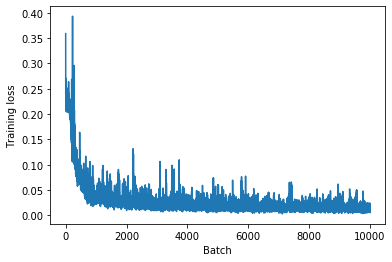

In [13]:
plt.plot(batch_idx, losses)
plt.xlabel('Batch')
plt.ylabel('Training loss')

In [14]:
noise, targets = generate_batch(eval_batch_size, input_params)
pred, hiddens  = gru(noise)
print("Loss on a new large batch: {}".format(loss(pred, targets).item())) 

Loss on a new large batch: 0.010500936768949032


## Fixed points

In [206]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 512        # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [207]:
gru = gru.to('cuda')
noise, targets = generate_batch(400, input_params)
_, hiddens = gru(noise)
hiddens.shape

torch.Size([25, 400, 100])

In [208]:
p_tols = [0.0001, 0.00001, 0.000001] # Used for both fp_tol and opt_stop_tol
fp_dict = {}
for tol in p_tols:
    opt_params = {
    'num_batches' : fp_num_batches, 
    'batch_size' : fp_batch_size,
      'step_size' : fp_step_size, 
      'decay_factor' : fp_decay_factor, 
      'decay_steps' : fp_decay_steps, 
      'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
      'noise_var' : fp_noise_var, 
      'fp_opt_stop_tol' : tol, 
      'fp_tol' : tol, 
      'unique_tol' : fp_unique_tol, 
      'outlier_tol' : fp_outlier_tol, 
      'opt_print_every' : fp_opt_print_every
    }


    candidates = hiddens.view(-1, 100)
    fp_dict[tol] = find_fps(gru.gru, torch.nn.Parameter(candidates), opt_params, device='cuda')    
    
        

Optimising to find fixed points
Optimising to find 10000 fixed points
Batches 8663-9175 in 0.00, Training loss 0.0002, LR 0.2000
Batches 201-713 in 0.01, Training loss 0.0004, LR 0.2000
kept 8783/10000 with speed check
kept 6783/8783 with uniqueness check
kept 6783/6783 with outlier check
Optimising to find fixed points
Optimising to find 10000 fixed points
Batches 2465-2977 in 0.00, Training loss 0.0001, LR 0.2000
kept 8328/10000 with speed check
kept 1300/8328 with uniqueness check
kept 1300/1300 with outlier check
Optimising to find fixed points
Optimising to find 10000 fixed points
Batches 766-1278 in 0.00, Training loss 0.0000, LR 0.2000
Batches 8550-9062 in 0.00, Training loss 0.0000, LR 0.2000
Batches 6871-7383 in 0.00, Training loss 0.0000, LR 0.2000
Batches 7547-8059 in 0.01, Training loss 0.0000, LR 0.2000
Batches 8243-8755 in 0.00, Training loss 0.0000, LR 0.2000
Batches 3267-3779 in 0.00, Training loss 0.0000, LR 0.2000
Batches 7194-7706 in 0.00, Training loss 0.0000, LR 0.

In [209]:
for tol in p_tols:
    torch.save(fp_dict[tol], f"fps_{tol}.pt")

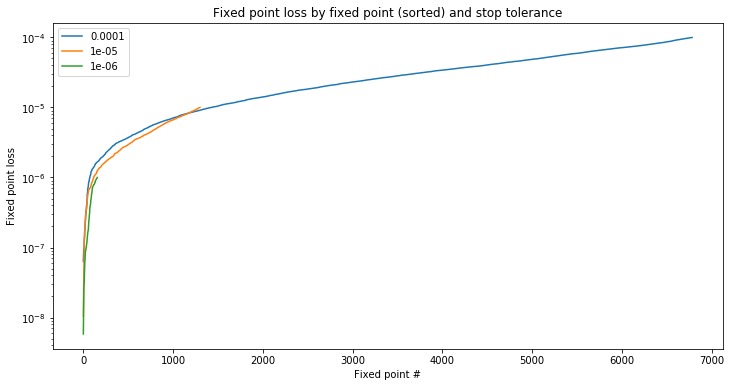

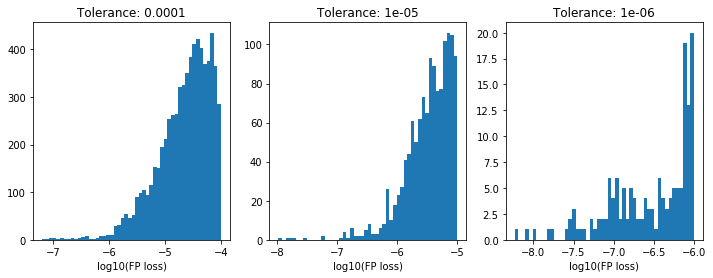

In [210]:
f1 = plt.figure(figsize=(12,6))

for tol in p_tols: 
    plt.semilogy(sorted(fp_dict[tol][1].detach().cpu())); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
plt.legend(p_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(p_tols)
for tol_idx, tol in enumerate(p_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(np.log10(fp_dict[tol][1].detach().cpu()), 50)
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol))

In [211]:
fps = fp_dict[0.00001][0].cpu()
gru = gru.to('cpu')

In [217]:
%matplotlib qt

In [243]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=3).fit(fp_candidates)


max_fps_to_plot = 1000
sizes = [100, 500]

hiddens = candidates.detach().cpu()

h_pca = pca.transform(hiddens)

emax = h_pca.shape[0] if h_pca.shape[0] < max_fps_to_plot else max_fps_to_plot

alpha = 0.01
#ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

hstars = np.reshape(fps, (-1, n))
hstar_pca = pca.transform(hstars)
color = np.squeeze(gru.readout(hstars)).detach()
color = np.where(color > 1.0, 1.0, color)
color = np.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0    

marker_style = dict(marker='*', s=200, edgecolor='gray')

ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
            c=color[0:emax], **marker_style);

for eidx in range(emax):
    ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
              [h_pca[eidx,1], hstar_pca[eidx,1]],
              [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])    

plt.title('Fixed point structure and fixed point candidate starting points.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');

def update(i):
    angle = np.arange(360)[i]
    ax.view_init(15, angle)
    plt.draw()
    plt.pause(.00001)
    

anim = FuncAnimation(fig, update, frames=np.arange(0, 60), interval=0.01)
anim.save('/media/STORAGE10TB/lucas/line.gif', dpi=50, writer='imagemagick')


        


In [259]:
readouts = gru.readout(fps).cpu().detach().numpy().squeeze()


sorted_idcs = np.argsort(readouts, axis=0)

In [258]:
readouts[sorted_idcs].shape

(10000,)

In [261]:
sorted_idxs = np.argsort(readouts, axis=0).squeeze()
sorted_fps = hstar_pca[sorted_idxs]

In [262]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [263]:
pca = PCA(3).fit(sorted_fps)
pc_fps = sorted_fps


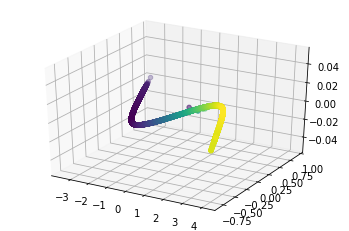

In [270]:
ax = plt.subplot(111, projection='3d')
ax.scatter(pc_fps.T[0], pc_fps.T[1], c=readouts[sorted_idxs].squeeze())


In [286]:

gru = gru.cuda()
fps = fps.cuda()
jacs = dynamics.compute_jacobians(gru.gru, fps, 100)

RuntimeError: input has inconsistent input_size: got 100, expected 1

In [272]:
fps.shape

torch.Size([10000, 100])